# pyphysio tutorial

## 3. Pipelines

In this tutorial we consider two pipelines for the processing of ECG and EDA signals respectively.

We divide the pipelines into three separate steps:
1. Filtering and Preprocessing: this step includes all the procedures aiming at increasing the signal/noise ratio, typycally band-pass filtering, smoothing, removal of artifacts. The output of this step is a new version of the imput signal with improved signal quality (less noise);
2. Information Extraction: this step aims at extracting the information of interest from the physiological signal. The output is a new signal containing only the information of interest and thus it has a **signal_nature** different from the input signal.
3. Physiological Indicators: this steps produces a list of scalar values able to describe the characteristics of the input signal. This step is usually performed on small segments of the input signals which are extracted using a sliding window on the whole length of the signal.

![algorithm](img/flowchart_processing.png)

*Figure 1: Representation of the three main steps of a signal processing pipeline. Below: example of the ideal results of each block on a Photo-PlethysmoGraph (PPG) signal. *

To understand how a signal processing step is represented in **pyphysio** see tutorial 2-algorithms

In the following code we will also use the shortened sintax to apply a signal processing step:

```python
# standard sintax: creation + execution
filter_iir = ph.IIRFilter(fp=45, fs = 50, ftype='ellip') # creation of the processing step
ecg_out = filter_iir(ecg) # execution on the input signal


# shortened sintax: creation(execution)
ecg_out = ph.IIRFilter(fp=45, fs = 50, ftype='ellip')(ecg)```

However, the standard sintax is suggested when applying the same processing steps to multiple signals or for the clarity of the scripts:

Es:
```python
filter_iir = ph.IIRFilter(fp=45, fs = 50, ftype='ellip') # creation of the processing step

ecg_1_out = filter_iir(ecg_1) # execution on the input signal
ecg_2_out = filter_iir(ecg_2) # execution on the input signal
ecg_3_out = filter_iir(ecg_3) # execution on the input signal
```

### 3.1 ECG processing pipeline

** Step 0: Import data **

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 

In [2]:
# import all pyphysio classes and methods
import pyphysio as ph

Please cite:
Bizzego et al. (2019) 'pyphysio: A physiological signal processing library for data science approaches in physiology', SoftwareX


In [3]:
# import data and creating a signal
import pyphysio.tests as test
ecg_data = test.TestData.ecg()

fsamp = 2048
ecg = ph.EvenlySignal(values = ecg_data, sampling_freq = fsamp, signal_type = 'ecg')

[-0.118 -0.117 -0.117 ... -0.016 -0.015 -0.017]


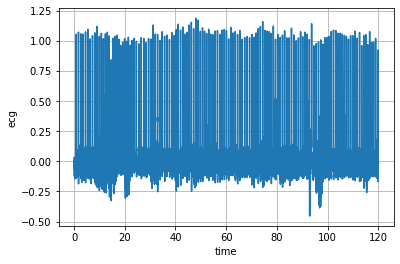

In [5]:
ecg.plot()
print(ecg)

To better understand how to develop a signal processing pipelines we imagine that the physiological signals were collected during an experiment in which the subject watched two images with different emotional content.

Specifically the experiment is composed of four parts:
* [  0s -  30s] - baseline
* [ 30s -  60s] - image 1
* [ 60s -  90s] - baseline
* [ 90s - 120s] - image 2

We store the information about the experimental sessions in an `EvenlySignal` signal appositely created:

In [6]:
# create label
label = np.zeros(1200)
label[300:600] = 1
label[900:1200] = 2

label = ph.EvenlySignal(label, sampling_freq = 10, signal_type = 'label')

Note that in some other cases a similar signal might be provided by design of the experiment, for instance by using markers or triggers.

** Step 1: Filtering and preprocessing **

In [7]:
# (optional) IIR filtering : remove high frequency noise
ecg = ph.IIRFilter(fp=45, fs = 50, ftype='ellip')(ecg)

In [8]:
# normalization : normalize data
ecg = ph.Normalize(norm_method='standard')(ecg)

In [9]:
# resampling : increase the sampling frequency by cubic interpolation
ecg = ecg.resample(fout=4096, kind='cubic')
fsamp = 4096

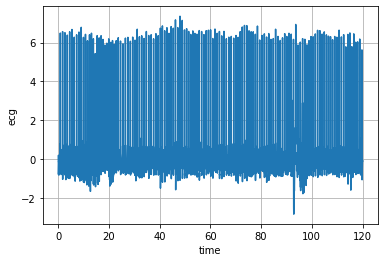

In [10]:
ecg.plot()

** Step 2: Information Extraction **

The information we want to extract from the ECG signal is the position of the heartbeats and the Inter Beat Interval signal.

In [11]:
ibi = ph.BeatFromECG()(ecg)

In [12]:
ibi.get_duration()

120.0

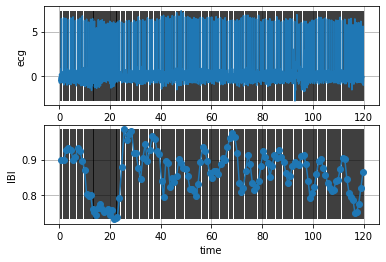

In [13]:
# check results so far
ax1 = plt.subplot(211)
ecg.plot()
plt.vlines(ibi.get_times(), np.min(ecg), np.max(ecg))

plt.subplot(212, sharex = ax1)
ibi.plot('o-')
plt.vlines(ibi.get_times(), np.min(ibi), np.max(ibi))
plt.show()

In [13]:
# edit IBI
# ibi_ok = ph.Annotate(ecg, ibi)()

** Step 3: Physiological Indicators **

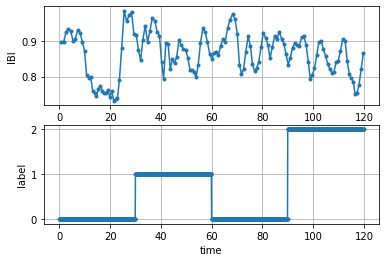

In [14]:
# check label
ax1 = plt.subplot(211)
ibi.plot('.-')

plt.subplot(212, sharex = ax1)
label.plot('.-')
plt.show()

In [15]:
# define a list of indicators we want to compute
hrv_indicators = [ph.Mean(name='RRmean'), ph.StDev(name='RRstd'), ph.RMSSD(name='rmsSD')]

In [16]:
#fixed length windowing
fixed_length = ph.FixedSegments(step = 5, width = 10, labels = label)

indicators, col_names = ph.fmap(fixed_length, hrv_indicators, ibi)

In [17]:
# extract column with the labels for each window
label_w = indicators[:, np.where(col_names == 'label')[0]]

# extract column with the RRmean values computed from each window
rrmean_w = indicators[:, np.where(col_names == 'RRmean')[0]]

rrmean_image1 = rrmean_w[np.where(label_w==1)[0]].ravel()
rrmean_image2 = rrmean_w[np.where(label_w==2)[0]].ravel()

{'whiskers': [<matplotlib.lines.Line2D at 0x1c1e3d9438>,
 'caps': [<matplotlib.lines.Line2D at 0x1c1e3d9b38>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c1e3d9048>,
 'medians': [<matplotlib.lines.Line2D at 0x1c1e3d9f60>,
 'fliers': [<matplotlib.lines.Line2D at 0x1c1e3e3550>,
 'means': []}

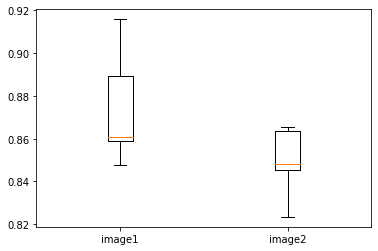

In [18]:
## create a box and whisker plot to compare the distibution of the RRmean indicator
plt.boxplot([rrmean_image1, rrmean_image2],
            labels=['image1', 'image2'])

`pyphysio` provides by default some presets of standard indicators for Heart Rate Variability and Electrodermal activity analysis.

Each indicator has its own pre-defined parameters:

In [19]:
HRV_FD = ph.preset_hrv_fd() #frequency domain HRV indicators
print(HRV_FD)

print(HRV_FD[0].get())

[IBI_VLF_Pow, IBI_LF_Pow, IBI_HF_Pow, IBI_Total_Pow]
{'freq_min': 1e-05, 'freq_max': 0.04, 'method': 'ar', 'interp_freq': 4, 'name': 'IBI_VLF_Pow'}


If a customization of the indicators is not required, it is easier to directly use them instead of manually define each indicator:

In [20]:
FD_HRV_ind, col_names = ph.fmap(fixed_length, ph.preset_hrv_fd(), ibi.resample(4))

If you need to export the results, for instance in a .csv datafile, you can use `pandas`:

In [21]:
import pandas as pd

# create a pandas dataframe
FD_HRV_df = pd.DataFrame(FD_HRV_ind, columns=col_names)

FD_HRV_df

,begin,end,label,IBI_VLF_Pow,IBI_LF_Pow,IBI_HF_Pow,IBI_Total_Pow
0,0.850098,10.850098,0.0,59.516601,203.751677,391.404224,1309.709483
1,5.850098,15.850098,0.0,264.439856,843.781813,394.526680,2082.863133
2,10.850098,20.850098,0.0,132.541890,349.282597,590.365659,1687.926380
3,15.850098,25.850098,0.0,89.239632,290.723129,409.507018,1423.139258
4,30.850098,40.850098,1.0,100.549819,316.695904,514.396912,1570.979730
5,35.850098,45.850098,1.0,230.816440,593.825096,750.872661,2177.812320
6,40.850098,50.850098,1.0,76.334252,266.728378,662.535907,1788.202972
7,45.850098,55.850098,1.0,173.964370,653.045174,523.428901,1961.157784
8,60.850098,70.850098,0.0,183.219677,593.111776,390.872019,1769.266383
9,65.850098,75.850098,0.0,275.869859,1173.359213,740.084483,2736.346689


In [22]:
# and save it to a .csv file:

#FD_HRV_df.to_csv('filename.csv')

In [23]:
# BE CAREFUL when executing the above command (uncomment first) 
# as it will save a new file in your current working directory.
# To check your current working directory:
import os
print(os.getcwd())

/media/veracrypt1/UniTn/software/pyphysio/tutorials


### 3.2 EDA processing pipeline

** Step 0: Import data **

[1.447 1.447 1.447 ... 2.027 2.027 2.027]


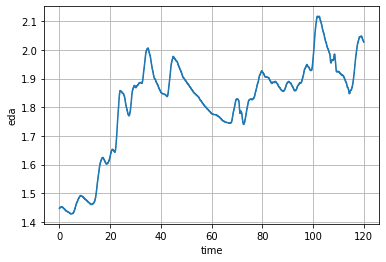

In [25]:
# import data and creating a signal

eda_data = test.TestData.eda()

fsamp = 2048
eda = ph.EvenlySignal(values = eda_data, sampling_freq = fsamp, signal_type = 'eda')

eda.plot()
print(eda)

** Step 1: Filtering and preprocessing **

In [21]:
# resampling : decrease the sampling frequency by cubic interpolation
eda = eda.resample(fout=8, kind='cubic')

In [22]:
# IIR filtering : remove high frequency noise
eda_filt = ph.IIRFilter(fp=0.8, fs = 1.1, ftype='ellip')(eda)

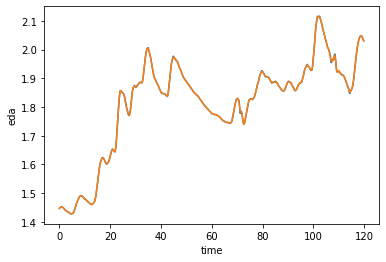

In [23]:
eda.plot()
eda_filt.plot()
eda = eda_filt

** Step 2: Information Extraction **

The information we want to extract from the EDA signal is the phasic component associated to the sympathetic activity.

In [9]:
# estimate the driver function
driver = ph.DriverEstim()(eda)

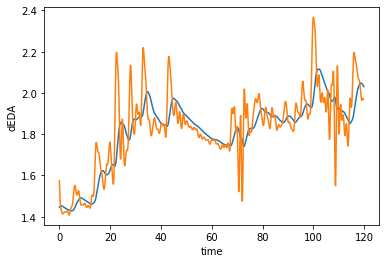

In [10]:
eda.plot()
driver.plot()

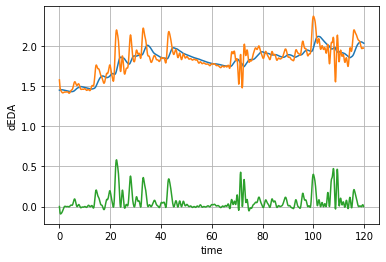

In [11]:
# compute the phasic component
phasic, tonic, _ = ph.PhasicEstim(delta=0.02)(driver)
eda.plot()
driver.plot()
phasic.plot()

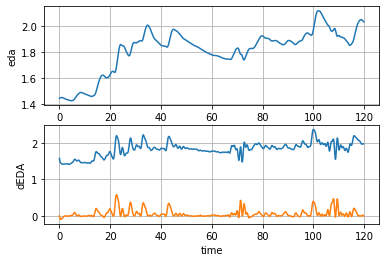

In [13]:
# check results so far
plt.figure()
ax1 = plt.subplot(211)
eda.plot()
#label.plot()

plt.subplot(212, sharex = ax1)
driver.plot()
phasic.plot()
plt.grid()
plt.show()

** Step 3: Physiological Indicators **

In [32]:
#fixed length windowing
fixed_length = ph.FixedSegments(step = 5, width = 20, labels = label)

# we use the preset indicators for the phasic signal.
# We need to define the minimum amplitude of the peaks that will be considered
PHA_ind, col_names = ph.fmap(fixed_length, ph.preset_phasic(delta=0.02), phasic)

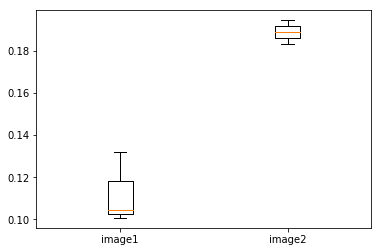

In [33]:
## Box-Whisker plot
## extract column with the labels for each window
label_w = PHA_ind[:, np.where(col_names == 'label')[0]]

## extract column with the PksMean values
## computed from each window
pksmean_w = PHA_ind[:, np.where(col_names == 'pha_PeaksMean')[0]]

pksmean_image1 = pksmean_w[np.where(label_w==1)[0]]
pksmean_image2 = pksmean_w[np.where(label_w==2)[0]]

## create a box and whisker plot 
## to compate the distibution of the RRmean indicator
plt.figure()
plt.boxplot([pksmean_image1, pksmean_image2], 
            labels=['image1', 'image2'])
plt.show()